In [1]:
import cv2
import bz2
import dlib
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.utils import get_file

from face3d import mesh
from face3d.morphable_model import MorphabelModel
from face3d.render_utils.render.render_operator import Render

def unpack_bz2(src_path):
    data = bz2.BZ2File(src_path).read()
    dst_path = src_path[:-4]
    with open(dst_path, 'wb') as fp:
        fp.write(data)
    return dst_path

def reverse_to_image(vertices, h, w, is_perspective = False):
    projected_vertices = vertices.copy()
    # flip vertics along y-axis
    projected_vertices[:, 1] = h - projected_vertices[:, 1] - 1
    # move to center of image
    projected_vertices[:, 0] -= w/2
    projected_vertices[:, 1] -= h/2
    if is_perspective:
        projected_vertices[:, 0] /= w/2
        projected_vertices[:, 1] /= h/2
    return projected_vertices

In [2]:
LANDMARKS_MODEL_URL = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
landmarks_model_path = unpack_bz2(get_file('shape_predictor_68_face_landmarks.dat.bz2', LANDMARKS_MODEL_URL, cache_subdir='temp'))

In [3]:
detector = dlib.get_frontal_face_detector()
landmarks_predictor = dlib.shape_predictor(landmarks_model_path)

In [4]:
img_path = 'examples/Data/aligned_0000_0001.png'

In [5]:
img = dlib.load_rgb_image(img_path)
show_img = img.copy()

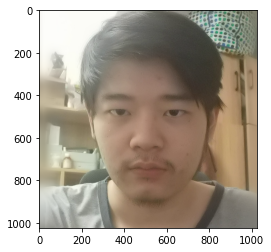

In [6]:
plt.imshow(img)

In [7]:
dets = detector(img, 1)

In [8]:
for detection in dets:
    face_landmarks = [(item.x, item.y) for item in landmarks_predictor(img, detection).parts()]
    show_img = cv2.rectangle(show_img, (detection.left(), detection.top()), (detection.right(), detection.bottom()), (0, 255, 0), 2)
    for i, landmark in enumerate(face_landmarks):
        cv2.circle(show_img, landmark, 5, (0, 255, 0), -1)
        # cv2.putText(show_img, str(i), landmark, cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 1)

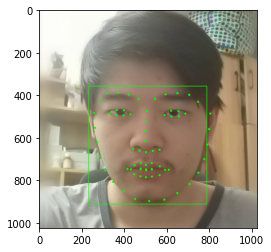

In [9]:
plt.imshow(show_img)

In [10]:
bfm = MorphabelModel('examples/Data/BFM/Out/BFM.mat')

In [11]:
h = w = 1024

In [82]:
x_face_landmarks = np.array(face_landmarks).astype('float64')
projected_vertices = reverse_to_image(x_face_landmarks, h, w)
X_ind = bfm.kpt_ind

In [83]:
fitted_sp, fitted_ep, fitted_s, fitted_angles, fitted_t = bfm.fit(projected_vertices, X_ind, max_iter = 3)

In [84]:
tp = bfm.get_tex_para('zero')
colors = bfm.generate_colors(tp)
colors = np.minimum(np.maximum(colors, 0), 1)

In [109]:
# verify fitted parameters
fitted_vertices = bfm.generate_vertices(fitted_sp, fitted_ep)
# fitted_vertices = bfm.generate_vertices(fitted_sp, bfm.get_exp_para('zero'))
transformed_vertices = bfm.transform(fitted_vertices, fitted_s, fitted_angles, fitted_t)

image_vertices = mesh.transform.to_image(transformed_vertices, h, w)
fitted_image = mesh.render.render_colors(image_vertices, bfm.triangles, colors, h, w)

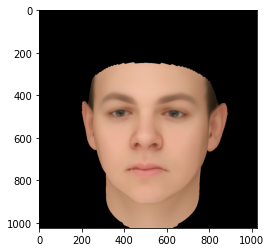

In [110]:
plt.imshow(fitted_image)

In [178]:
transformed_vertices = bfm.transform(fitted_vertices, fitted_s, fitted_angles, fitted_t)
transformed_vertices = bfm.transform(transformed_vertices, 1, [0, 180, 0], [0, 0, 0])
image_vertices = mesh.transform.to_image(transformed_vertices, h, w)

In [181]:
img3 = RenderAgent(np.flip(img, 1), image_vertices, bfm.triangles)

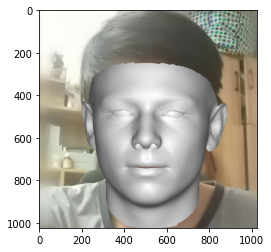

In [183]:
plt.imshow(np.flip(img3, 1))

In [126]:
fitted_vertices = bfm.generate_vertices(fitted_sp, bfm.get_exp_para('zero'))
transformed_vertices = bfm.transform(fitted_vertices, fitted_s, [0, 180, 0], [0, 0, 0])
image_vertices = mesh.transform.to_image(transformed_vertices, h, w)

z = -image_vertices[:, 2:]
attribute = (z - np.min(z))/(np.max(z) - np.min(z))

image_render = RenderAgent(np.ones_like(img), image_vertices, bfm.triangles)

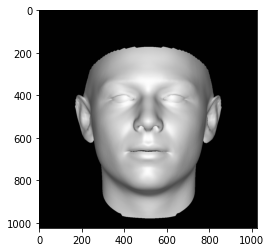

In [127]:
plt.imshow(image_render)

In [81]:
cv2.imwrite('test_frontal.png', image_render)

True

In [39]:
fitted_image = cv2.rectangle(fitted_image, (detection.left(), detection.top()), (detection.right(), detection.bottom()), (0, 255, 0), 2)

In [40]:
image_landmarks = image_vertices[bfm.kpt_ind, :2]
for i, landmark in enumerate(image_landmarks):
    cv2.circle(fitted_image, tuple((landmark).astype('int')), 5, (255, 0, 0), -1)
for i, landmark in enumerate(face_landmarks):
    cv2.circle(fitted_image, landmark, 5, (0, 255, 0), -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


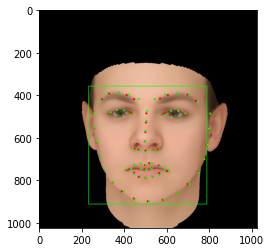

In [41]:
plt.imshow(fitted_image)

In [44]:
# --- 1. load model
bfm = MorphabelModel('examples/Data/BFM/Out/BFM.mat')

In [45]:
# --- 2. generate face mesh: vertices(represent shape) & colors(represent texture)
sp = bfm.get_shape_para('random')
ep = bfm.get_exp_para('random')
vertices = bfm.generate_vertices(sp, ep)

tp = bfm.get_tex_para('zero')
colors = bfm.generate_colors(tp)
colors = np.minimum(np.maximum(colors, 0), 1)

In [46]:
# --- 3. transform vertices to proper position
s = 4e-03
angles = [0, 0, 0]
t = [0, 0, 0]
transformed_vertices = bfm.transform(vertices, s, angles, t)
projected_vertices = transformed_vertices.copy() # using stantard camera & orth projection

In [76]:
# --- 4. render(3d obj --> 2d image)
# set prop of rendering
h = w = 1024
image_vertices = mesh.transform.to_image(projected_vertices, h, w)

z = image_vertices[:, 2:]
attribute = (z - np.min(z))/(np.max(z) - np.min(z))
image_render = mesh.render.render_colors(image_vertices, bfm.triangles, attribute, h, w, c=1)

image_landmarks = image_vertices[bfm.kpt_ind, :2]

In [77]:
image_render_show = image_render.copy()

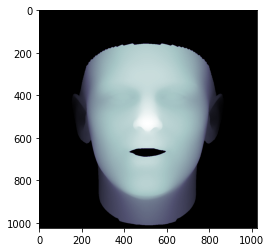

In [78]:
plt.imshow(image_render, cmap='bone')

In [81]:
np.max(image_render)

0.99996465

In [82]:
cv2.imwrite('depth_render.png', image_render * 255)

True

In [26]:
for i, landmark in enumerate(image_landmarks):
    cv2.circle(image_render_show, tuple((landmark).astype('int')), 5, (0, 255, 0), -1)
    # cv2.putText(image_render_show, str(i), tuple((landmark).astype('int')), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


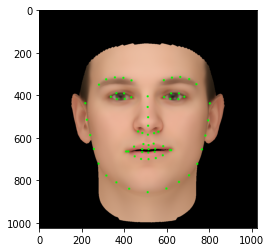

In [27]:
plt.imshow(image_render_show)

In [28]:
# -------------------- Back:  2D image points and corresponding 3D vertex indices-->  parameters(pose, shape, expression) ------
## only use 68 key points to fit
x = projected_vertices[bfm.kpt_ind, :2] # 2d keypoint, which can be detected from image
X_ind = bfm.kpt_ind # index of keypoints in 3DMM. fixed.

# fit
fitted_sp, fitted_ep, fitted_s, fitted_angles, fitted_t = bfm.fit(x, X_ind, max_iter = 3)

In [29]:
# verify fitted parameters
fitted_vertices = bfm.generate_vertices(fitted_sp, fitted_ep)
fitted_vertices = bfm.generate_vertices(fitted_sp, bfm.get_exp_para('zero'))
transformed_vertices = bfm.transform(fitted_vertices, fitted_s, fitted_angles, fitted_t)

image_vertices = mesh.transform.to_image(transformed_vertices, h, w)
image_landmarks_fitted = image_vertices[bfm.kpt_ind, :2]

fitted_image = mesh.render.render_colors(image_vertices, bfm.triangles, colors, h, w)

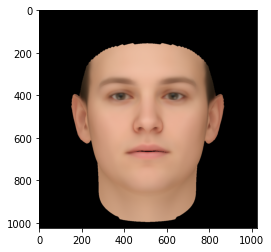

In [30]:
plt.imshow(fitted_image)

In [31]:
for i, landmark in enumerate(image_landmarks):
    cv2.circle(fitted_image, tuple((landmark).astype('int')), 5, (0, 255, 0), -1)

for i, landmark in enumerate(image_landmarks_fitted):
    cv2.circle(fitted_image, tuple((landmark).astype('int')), 5, (255, 0, 0), -1)
    # cv2.putText(image_render_show, str(i), tuple((landmark).astype('int')), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


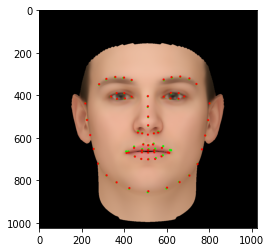

In [32]:
plt.imshow(fitted_image)

In [33]:
# ------------- print & show 
print('pose, groudtruth: \n', s, angles[0], angles[1], angles[2], t[0], t[1])
print('pose, fitted: \n', fitted_s, fitted_angles[0], fitted_angles[1], fitted_angles[2], fitted_t[0], fitted_t[1])

pose, groudtruth: 
 0.004 0 0 0 0 0
pose, fitted: 
 0.003972342703491449 -0.864888350203912 0.3403860971512076 0.09186560440549074 -1.1652808 -2.8697166


In [42]:
transformed_vertices.shape

(53215, 3)

In [43]:
fitted_vertices.shape

(53215, 3)